<center> <h1>BATCH NORMALIZATION</h1>

<h3>torch.nn.BatchNorm1D and torch.nn.BatchNorm2D
	
</h3> 
<hr>
<h3>Nika Jerković</h3>

# How it works?

**Normalization in general**

When inputting data to a deep learning model, it is standard practice to normalize the data to zero mean and unit variance. Each feature might have a **different range** of values. For instance, values for feature x1 might range from 0 through 1, while values for feature x2 might range from 1000 to 99999. So, for each feature column separately, we take the values of all samples in the dataset, compute the mean and the variance and normalize the values using the formula $X_i = \frac{X_i - \ Mean_i}{\ StdDev_i}$.

In the picture below, we can see the effect of normalizing data. The original values (in blue) are now centered around zero (in red). This ensures that all the feature values are now on the same scale.


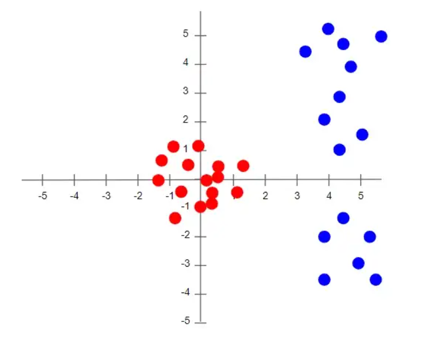


Normalizing the inputs to a neural network is important for several reasons:


*   By bringing the input values to a similar range, the optimization algorithm can traverse the parameter space more effectively and find the optimal values for the weights more efficiently.
*   By making the input values more similar in scale, the network is less likely to over-fit the data, and this can improve generalization performance.
*   When the input values have a different range, it can cause some features to dominate the input. Normalizing the inputs reduces the impact of these irrelevant features and makes the network more robust.
*   By making the input values more similar in scale, it is easier to understand how each feature is contributing to the final prediction.













<hr>

Consider any of the hidden layers of a network. The activations from the previous layer are simply the inputs to this layer. For instance, from the perspective of Layer 2, if we “blank out” all the previous layers, the activations coming from Layer 1 are no different from the original inputs.

The need to normalize the input for the first layer applies to each of these hidden layers as well. This means that normalizing the activations from each previous layer can lead to better convergence during training, as the gradient descent will be optimized.

**Batch Normalization** is an algorithmic method which makes the training of Deep Neural Networks (expecially CNNs) faster and more stable.

It consists of normalizing activation vectors from hidden layers using the first and the second statistical moments (mean and variance) of the current batch. This normalization step is applied right before (or right after) the nonlinear function.

Here is example of Multilayer Perceptron (MLP) without batch normalization and with batch normalization: 

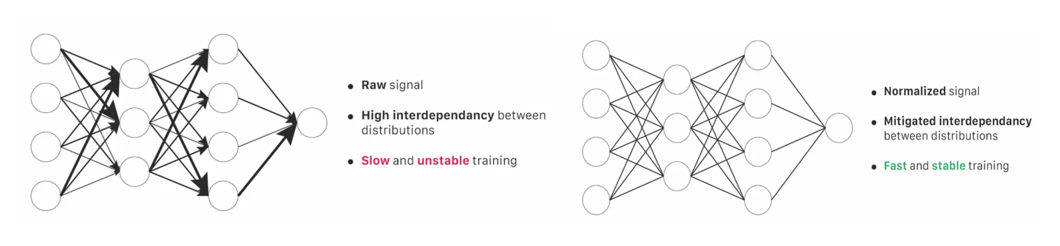


Batch Norm is just another **network layer** that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.

Batch Norm layer also has parameters of its own:


*   Two learnable parameters: beta and gamma.
*   Two non-learnable parameters(saved as part of the ‘state’ of the Batch Norm layer): Mean Moving Average and Variance Moving Average


During training, we feed the network one mini-batch of data at a time. During the forward pass, each layer of the network processes that mini-batch of data. The Batch Norm layer processes its data as follows:

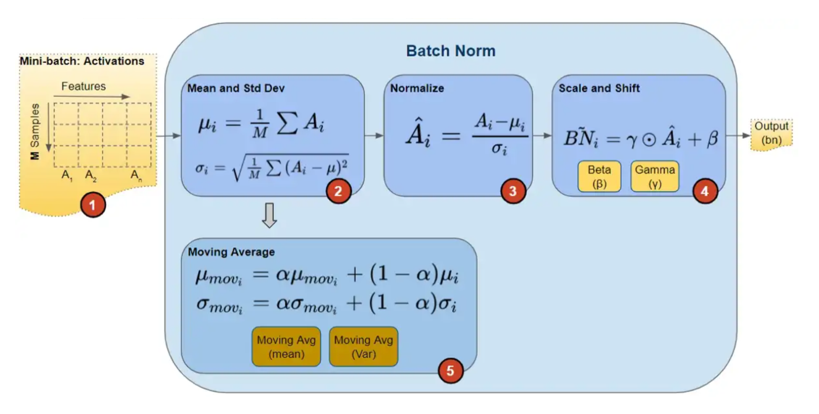



1.   The Batch Norm layer receives activation vectors from the previous layer, one activation vector for each feature in the data.
2.   For each activation vector separately, calculate the mean and variance of all the values in the mini-batch.
3. The normalized values for each activation vector are determined using the corresponding mean and variance.
4. Unlike the input layer,Batch Norm allows its values to be shifted (to a different mean) and scaled (to a different variance). It does this by multiplying the normalized values by a factor, gamma, and adding to it a factor, beta. These factors are not hyperparameters, but are trainable parameters that are learned by the network. Each Batch Norm layer is able to optimally find the best factors for itself, and can thus shift and scale the normalized values to get the best predictions.
5. The Batch Norm layer also tracks the Moving Average of mean and variance, which is calculated during training and stored as part of the layer’s state but not used until inference, and is updated with a scalar "momentum" (alpha).




Batch Normalization **during inference** refers to using the mean and variance calculated during training to normalize the input data in the test phase. It helps to ensure that the model has similar inputs to what it saw during training, leading to more stable and accurate predictions. 

During Training Batch Norm starts by calculating the mean and variance for a mini-batch. However, during Inference, we have a single sample, not a mini-batch. In that case we use saved Moving Average parameters.

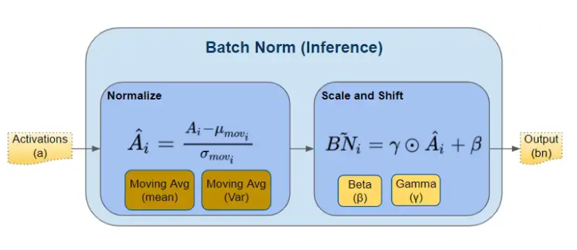

During training, calculating and saving the mean and variance for the full dataset is not feasible due to the high memory requirements.To overcome this challenge, the Moving Average is used as an efficient proxy for the mean and variance of the data. It is much more efficient because the calculation is incremental — we have to remember only the most recent Moving Average.






# Implementation

In [1]:
import numpy as np
import torch

We define function for checking if two tensors are the same. The input parameters are tensor1-PyTorch tensor, tensor2-another PyTorch tensor and
tolerance-maximum allowed difference between corresponding elements in the two tensors for them to be considered equal. 

The function first converts the tensors to float type using the .detach().float() method(there are some minor differences in types and this solves the problem). Then, the torch.allclose function is used to compare the two tensors and determine if they are **close enough** to be considered equal, given the tolerance value.

In [2]:
def check_if_same(tensor1, tensor2, tolerance):
  tensor1 = tensor1.detach().float()
  tensor2 = tensor2.detach().float()

  if torch.allclose(tensor1, tensor2,atol=tolerance):
    print("Tensors are the same.")
  else:
    print("Tensors are not the same.")

As explained before, BatchNorm is defined as:


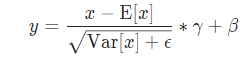

*Note:* In the following, the previously mentioned Moving Average Parameters are called **running_mean** and **running_var**. 

## BatchNorm1D

The class has several inputs:

*   **num_features**: The number of features in the input data
*   **eps**: A small constant added to the variance of the input data to avoid division by zero
*   **momentum**: The decay rate for computing the running mean and variance(It determines the contribution of the new mini-batch mean and variance to the running mean and variance)
*   **learnable**: A boolean value indicating whether the scaling (gamma) and shifting (beta) parameters are learnable or not
*   **gamma**: An optional parameter for the scaling factor, if not specified, the default value is set to 1
*   **beta**: An optional parameter for the shifting factor, if not specified, the default value is set to 0


If learnable is True, then gamma and beta are initialized as specified in the input or with default. If learnable is False, then gamma and beta are set to 1 and 0 - that is the same as no learnable parametars because 1 is a neutral element for multiplication and 0 for addition. 

The forward method takes an input tensor x and calculates the mean and variance of the mini-batch, batch_mean and batch_var, respectively. These values are used to update the running mean and variance, self.running_mean and self.running_var.

The input tensor x is then normalized by subtracting batch_mean and dividing by the square root of batch_var + self.eps. If self.learnable is True, the normalized input is scaled by self.gamma and shifted by self.beta. The normalized and possibly scaled and shifted input tensor is then returned as the output of the forward method.


In [3]:
class BatchNorm1D:
    def __init__(self, num_features, eps=1e-5, momentum=0.1, learnable=False, gamma=None, beta=None):
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.learnable = learnable

        if self.learnable:
            if gamma is None:
                self.gamma = np.ones(num_features)
            else:
                self.gamma = gamma
            if beta is None:
                self.beta = np.zeros(num_features)
            else:
                self.beta = beta
        else:
            self.gamma = np.ones(num_features)
            self.beta = np.zeros(num_features)

        self.running_mean = np.zeros(num_features)
        self.running_var = np.ones(num_features)

    def forward(self, x):
        # calculate the mean and variance of the mini-batch
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)

        # update the running mean and variance
        self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * batch_mean
        self.running_var = self.momentum * self.running_var + (1 - self.momentum) * batch_var

        # normalize the input
        x = (x - batch_mean) / np.sqrt(batch_var + self.eps)

        # apply the learnable parameters
        if self.learnable:
            x = self.gamma * x + self.beta

        return x


We chose smaller batch size and number of features so that we could compare the tensors at first glance.

In [4]:
# create an input tensor of shape (batch_size, num_features)
batch_size = 5
num_features = 4
input_tensor = np.random.randn(batch_size, num_features)
print(input_tensor)

[[ 0.26418351  0.61275349  0.04335386  0.41961219]
 [-0.00907425  0.7140363   0.67426373 -1.04748879]
 [-0.76391214 -0.16717357  0.76370876  0.74055092]
 [ 2.31222769  0.52831895 -0.81870804 -2.41612102]
 [-0.04321948 -0.85944997 -1.62849407  2.09130919]]


### Without learnable parameters

In [5]:
# initialize the BatchNorm1D layer
bn = BatchNorm1D(num_features)

# apply the forward pass of the layer on the input tensor
output_tensor = bn.forward(input_tensor)
output_tensor = torch.Tensor(output_tensor)
print(output_tensor)

tensor([[-0.0847,  0.7464,  0.2588,  0.2979],
        [-0.3481,  0.9155,  0.9492, -0.6481],
        [-1.0756, -0.5557,  1.0471,  0.5049],
        [ 1.8893,  0.6054, -0.6845, -1.5307],
        [-0.3810, -1.7115, -1.5706,  1.3759]])


In [6]:
# create a torch tensor from the numpy array
input_tensor_pytorch = torch.Tensor(input_tensor)

# initialize the torch BatchNorm1d layer
bn_pytorch = torch.nn.BatchNorm1d(num_features,affine=False)

# apply the forward pass of the layer on the input tensor
output_tensor_pytorch = bn_pytorch(input_tensor_pytorch)
print(output_tensor_pytorch)

tensor([[-0.0847,  0.7464,  0.2588,  0.2979],
        [-0.3481,  0.9155,  0.9492, -0.6481],
        [-1.0756, -0.5557,  1.0471,  0.5049],
        [ 1.8893,  0.6054, -0.6845, -1.5307],
        [-0.3810, -1.7115, -1.5706,  1.3759]])


In [7]:
tolerance = 1e-08
check_if_same(output_tensor,output_tensor_pytorch, tolerance)

Tensors are the same.


### With default learnable parameters

In [8]:
# initialize the BatchNorm1D layer with learable parameters
bn = BatchNorm1D(num_features,learnable=True)

# apply the forward pass of the layer on the input tensor
output_tensor = bn.forward(input_tensor)
output_tensor = torch.Tensor(output_tensor)
print(output_tensor)

tensor([[-0.0847,  0.7464,  0.2588,  0.2979],
        [-0.3481,  0.9155,  0.9492, -0.6481],
        [-1.0756, -0.5557,  1.0471,  0.5049],
        [ 1.8893,  0.6054, -0.6845, -1.5307],
        [-0.3810, -1.7115, -1.5706,  1.3759]])


In [9]:
# initialize the torch BatchNorm1d layer with learable parameters
bn_pytorch = torch.nn.BatchNorm1d(num_features,affine=True)
for name, param in bn_pytorch.named_parameters():
  if "weight" in name:
    print(param)
  if "bias" in name:
    print(param)

Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True)


In the above output, we see that the default values ​​in pytorch are the same as the ones we defined in our implementation.

In [10]:
# apply the forward pass of the layer on the input tensor
output_tensor_pytorch = bn_pytorch(input_tensor_pytorch)
print(output_tensor_pytorch)

tensor([[-0.0847,  0.7464,  0.2588,  0.2979],
        [-0.3481,  0.9155,  0.9492, -0.6481],
        [-1.0756, -0.5557,  1.0471,  0.5049],
        [ 1.8893,  0.6054, -0.6845, -1.5307],
        [-0.3810, -1.7115, -1.5706,  1.3759]],
       grad_fn=<NativeBatchNormBackward0>)


In [11]:
tolerance = 1e-08
check_if_same(output_tensor,output_tensor_pytorch, tolerance)

Tensors are the same.


We notice that using default parameters, we get the same result as when we did not use learable parameters because default parameters are actually defined as neutral elements for addition and multiplication.

### With specific learnable parameters

In [12]:
gamma = torch.rand(num_features)
beta = torch.rand(num_features)
print(gamma) 
print(beta) 

tensor([0.4550, 0.5401, 0.4414, 0.2228])
tensor([0.2487, 0.2098, 0.0493, 0.8452])


In [13]:
# initialize the BatchNorm1D layer with specific learnable parameters
bn = BatchNorm1D(num_features,learnable=True, gamma = gamma, beta = beta)

# apply the forward pass of the layer on the input tensor
output_tensor = bn.forward(input_tensor)
output_tensor = torch.Tensor(output_tensor)
print(output_tensor)

tensor([[ 0.2102,  0.6128,  0.1635,  0.9116],
        [ 0.0903,  0.7042,  0.4683,  0.7008],
        [-0.2407, -0.0904,  0.5115,  0.9577],
        [ 1.1084,  0.5367, -0.2529,  0.5042],
        [ 0.0754, -0.7146, -0.6440,  1.1518]], dtype=torch.float64)


In [14]:
# initialize the torch BatchNorm1d layer with learnable parameters
bn_pytorch = torch.nn.BatchNorm1d(num_features,affine=True)

# changing default parameters to specific ones
bn_pytorch.weight.data = gamma
bn_pytorch.bias.data = beta

for name, param in bn_pytorch.named_parameters():
  if "weight" in name:
    print(param)
  if "bias" in name:
    print(param)

Parameter containing:
tensor([0.4550, 0.5401, 0.4414, 0.2228], requires_grad=True)
Parameter containing:
tensor([0.2487, 0.2098, 0.0493, 0.8452], requires_grad=True)


In [15]:
# apply the forward pass of the layer on the input tensor
output_tensor_pytorch = bn_pytorch(input_tensor_pytorch)
print(output_tensor_pytorch)

tensor([[ 0.2102,  0.6128,  0.1635,  0.9116],
        [ 0.0903,  0.7042,  0.4683,  0.7008],
        [-0.2407, -0.0904,  0.5115,  0.9577],
        [ 1.1084,  0.5367, -0.2529,  0.5042],
        [ 0.0754, -0.7146, -0.6440,  1.1518]],
       grad_fn=<NativeBatchNormBackward0>)


In [16]:
tolerance = 1e-08
check_if_same(output_tensor,output_tensor_pytorch, tolerance)

Tensors are the same.


## BatchNorm2D

The main difference between BatchNorm1D and BatchNorm2D is the shape of the input data and the dimensions used to compute the mean and variance. In BatchNorm1D, the input is a 1D array of shape (batch_size, num_features) and the mean and variance are computed along the axis=0 dimension.

On the other hand, in BatchNorm2D, the input is a 4D array of shape (batch_size, num_features, height, width) and the mean and variance are computed along the axis=(0,2,3) dimensions, which includes the batch_size, height, and width dimensions. The shapes of batch_mean and batch_var are (num_features,) which represent the mean and variance for each feature. The shape of x is (batch_size, num_features, height, width). To perform element-wise subtraction and division, the shapes of batch_mean and batch_var need to be broadcasted to match the shape of x. This is achieved by adding new dimensions to batch_mean and batch_var with the [None,:,None,None] indexing. After this, the shape of batch_mean will be (1, num_features, 1, 1) and the shape of batch_var will be (1, num_features, 1, 1). This allows the subtraction and division to be performed element-wise across the features dimension.

If self.learnable is True, then the self.gamma and self.beta are applied to the normalized input x. The shapes of self.gamma and self.beta are (num_features,), so they are broadcasted to the shape of x by adding new dimensions with the [None,:, None,None] indexing. After this, the shape of self.gamma will be (1, num_features, 1, 1) and the shape of self.beta will be (1, num_features, 1, 1). The multiplication and addition are then performed element-wise across the features dimension.

The rest of the implementation, including the calculation of the running mean and variance, normalization, and learnable parameters, remains the same.





In [17]:
class BatchNorm2D:
    def __init__(self, num_features, eps=1e-5, momentum=0.1, learnable=False, gamma=None, beta=None):
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.learnable = learnable

        if self.learnable:
            if gamma is None:
                self.gamma = np.ones(num_features)
            else:
                self.gamma = gamma
            if beta is None:
                self.beta = np.zeros(num_features)
            else:
                self.beta = beta
        else:
            self.gamma = np.ones(num_features)
            self.beta = np.zeros(num_features)

        self.running_mean = np.zeros(num_features)
        self.running_var = np.ones(num_features)
    
    def forward(self, x):
        # calculate the mean and variance of the mini-batch
        batch_mean = np.mean(x, axis=(0,2,3))
        batch_var = np.var(x, axis=(0,2,3))
        
        # update the running mean and variance
        self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * batch_mean
        self.running_var = self.momentum * self.running_var + (1 - self.momentum) * batch_var
        
        # mean and variance are broadcasted along axes 1, 2, and 3 to match the shape of x
        # the result is the normalized input tensor x with the same shape as the input
        x = (x - batch_mean[None,:,None,None]) / np.sqrt(batch_var[None,:,None,None] + self.eps)
        
        # apply the learnable parameters
        if self.learnable:
            # gamma and beta tensors are broadcasted along axes 1, 2, and 3 to match the shape of x
            x = self.gamma[None,:, None,None] * x + self.beta[None,:,None,None]

        return x


We chose smaller batch size, number of features, width and height so that we could compare the tensors at first glance.

In [18]:
# create an input tensor of shape (batch_size, num_features, width, height)
batch_size = 2
num_features = 2
width = height = 3
input_tensor = np.random.randn(batch_size, num_features, width, height)
print(input_tensor)

[[[[ 9.18503480e-01  9.56349425e-02 -1.61920213e-02]
   [-3.44940677e-01  4.27869991e-01 -7.88376835e-01]
   [ 1.49622762e-01 -5.65939508e-01  1.41238262e+00]]

  [[ 1.87566271e+00 -4.33837354e-01 -2.99316579e-03]
   [ 3.51433541e-01  7.20795642e-01  1.39866353e-01]
   [-1.37856731e-01 -2.08603757e-01 -3.57489290e+00]]]


 [[[-1.94939736e-01 -1.89576589e+00  1.54240600e+00]
   [-3.68632421e-01  1.19365485e+00 -1.05965945e-01]
   [-5.59878985e-01  1.04940905e+00  1.17929211e-01]]

  [[ 1.27850008e+00  1.99716780e+00 -1.33136153e+00]
   [ 5.76650940e-01  9.01690253e-01  5.80541129e-01]
   [-5.54517113e-01 -3.33772627e-01  3.16402911e-01]]]]


### Without learnable parameters

In [19]:
# initialize the BatchNorm2D layer
bn = BatchNorm2D(num_features)

# apply the forward pass of the layer on the input tensor
output_tensor = bn.forward(input_tensor)
output_tensor = torch.Tensor(output_tensor)
print(output_tensor)

tensor([[[[ 0.9498, -0.0227, -0.1548],
          [-0.5433,  0.3700, -1.0674],
          [ 0.0411, -0.8045,  1.5334]],

         [[ 1.4510, -0.4578, -0.1017],
          [ 0.1912,  0.4965,  0.0164],
          [-0.2132, -0.2716, -3.0539]]],


        [[[-0.3661, -2.3761,  1.6871],
          [-0.5713,  1.2749, -0.2609],
          [-0.7973,  1.1045,  0.0037]],

         [[ 0.9575,  1.5515, -1.1996],
          [ 0.3774,  0.6460,  0.3806],
          [-0.5575, -0.3751,  0.1623]]]])


In [20]:
# create a torch tensor from the numpy array
input_tensor_pytorch = torch.Tensor(input_tensor)

In [21]:
# initialize the torch BatchNorm2d layer
bn_pytorch = torch.nn.BatchNorm2d(num_features,affine=False)

# apply the forward pass of the layer on the input tensor
output_tensor_pytorch = bn_pytorch(input_tensor_pytorch)
print(output_tensor_pytorch)

tensor([[[[ 0.9498, -0.0227, -0.1548],
          [-0.5433,  0.3700, -1.0674],
          [ 0.0411, -0.8045,  1.5334]],

         [[ 1.4510, -0.4578, -0.1017],
          [ 0.1912,  0.4965,  0.0164],
          [-0.2132, -0.2716, -3.0539]]],


        [[[-0.3661, -2.3761,  1.6871],
          [-0.5713,  1.2749, -0.2609],
          [-0.7973,  1.1045,  0.0037]],

         [[ 0.9575,  1.5515, -1.1996],
          [ 0.3774,  0.6460,  0.3806],
          [-0.5575, -0.3751,  0.1623]]]])


In [22]:
tolerance = 1e-08
check_if_same(output_tensor,output_tensor_pytorch, tolerance)

Tensors are the same.


### With default learnable parameters

In [23]:
# initialize the BatchNorm2D layer with learnable parameters
bn = BatchNorm2D(num_features,learnable=True)

# apply the forward pass of the layer on the input tensor
output_tensor = bn.forward(input_tensor)
output_tensor = torch.Tensor(output_tensor)
print(output_tensor)

tensor([[[[ 0.9498, -0.0227, -0.1548],
          [-0.5433,  0.3700, -1.0674],
          [ 0.0411, -0.8045,  1.5334]],

         [[ 1.4510, -0.4578, -0.1017],
          [ 0.1912,  0.4965,  0.0164],
          [-0.2132, -0.2716, -3.0539]]],


        [[[-0.3661, -2.3761,  1.6871],
          [-0.5713,  1.2749, -0.2609],
          [-0.7973,  1.1045,  0.0037]],

         [[ 0.9575,  1.5515, -1.1996],
          [ 0.3774,  0.6460,  0.3806],
          [-0.5575, -0.3751,  0.1623]]]])


In [24]:
# initialize the torch BatchNorm2d layer with learnable parameters
bn_pytorch = torch.nn.BatchNorm2d(num_features,affine=True)

for name, param in bn_pytorch.named_parameters():
  if "weight" in name:
    print(param)
  if "bias" in name:
    print(param)

Parameter containing:
tensor([1., 1.], requires_grad=True)
Parameter containing:
tensor([0., 0.], requires_grad=True)


In the above output, we see that the default values ​​in pytorch are the same as the ones we defined in our implementation.

In [25]:
# apply the forward pass of the layer on the input tensor
output_tensor_pytorch = bn_pytorch(input_tensor_pytorch)
print(output_tensor_pytorch)

tensor([[[[ 0.9498, -0.0227, -0.1548],
          [-0.5433,  0.3700, -1.0674],
          [ 0.0411, -0.8045,  1.5334]],

         [[ 1.4510, -0.4578, -0.1017],
          [ 0.1912,  0.4965,  0.0164],
          [-0.2132, -0.2716, -3.0539]]],


        [[[-0.3661, -2.3761,  1.6871],
          [-0.5713,  1.2749, -0.2609],
          [-0.7973,  1.1045,  0.0037]],

         [[ 0.9575,  1.5515, -1.1996],
          [ 0.3774,  0.6460,  0.3806],
          [-0.5575, -0.3751,  0.1623]]]], grad_fn=<NativeBatchNormBackward0>)


In [26]:
tolerance = 1e-08
check_if_same(output_tensor,output_tensor_pytorch, tolerance)

Tensors are the same.


We notice that using default parameters, we get the same result as when we did not use learable parameters because default parameters are actually defined as neutral elements for addition and multiplication.

### With specific learnable parameters

In [27]:
# initialize the BatchNorm2D layer with specific learnable parameters
gamma = torch.rand(num_features)
beta = torch.rand(num_features)
print(gamma)
print(beta)

tensor([0.4451, 0.6823])
tensor([0.5268, 0.6919])


In [28]:
# initialize the BatchNorm2D layer with specific learnable parameters
bn = BatchNorm2D(num_features,learnable=True, gamma = gamma, beta = beta)

# apply the forward pass of the layer on the input tensor
output_tensor = bn.forward(input_tensor)
output_tensor = torch.Tensor(output_tensor)
print(output_tensor)

tensor([[[[ 0.9495,  0.5167,  0.4579],
          [ 0.2850,  0.6915,  0.0517],
          [ 0.5451,  0.1687,  1.2093]],

         [[ 1.6820,  0.3795,  0.6225],
          [ 0.8224,  1.0307,  0.7031],
          [ 0.5464,  0.5065, -1.3919]]],


        [[[ 0.3639, -0.5308,  1.2777],
          [ 0.2725,  1.0943,  0.4107],
          [ 0.1719,  1.0184,  0.5284]],

         [[ 1.3452,  1.7505, -0.1266],
          [ 0.9494,  1.1327,  0.9516],
          [ 0.3115,  0.4360,  0.8026]]]], dtype=torch.float64)


In [29]:
# initialize the torch BatchNorm2d layer with specific learnable parameters
bn_pytorch = torch.nn.BatchNorm2d(num_features,affine=True)


# changing default parameters to specific ones
bn_pytorch.weight.data = gamma
bn_pytorch.bias.data = beta

for name, param in bn_pytorch.named_parameters():
  if "weight" in name:
    print(param)
  if "bias" in name:
    print(param)

Parameter containing:
tensor([0.4451, 0.6823], requires_grad=True)
Parameter containing:
tensor([0.5268, 0.6919], requires_grad=True)


In [30]:
# apply the forward pass of the layer on the input tensor
output_tensor_pytorch = bn_pytorch(input_tensor_pytorch)
print(output_tensor_pytorch)

tensor([[[[ 0.9495,  0.5167,  0.4579],
          [ 0.2850,  0.6915,  0.0517],
          [ 0.5451,  0.1687,  1.2093]],

         [[ 1.6820,  0.3795,  0.6225],
          [ 0.8224,  1.0307,  0.7031],
          [ 0.5464,  0.5065, -1.3919]]],


        [[[ 0.3639, -0.5308,  1.2777],
          [ 0.2725,  1.0943,  0.4107],
          [ 0.1719,  1.0184,  0.5284]],

         [[ 1.3452,  1.7505, -0.1266],
          [ 0.9494,  1.1327,  0.9516],
          [ 0.3115,  0.4360,  0.8026]]]], grad_fn=<NativeBatchNormBackward0>)


In [31]:
tolerance = 1e-08
check_if_same(output_tensor,output_tensor_pytorch, tolerance)

Tensors are the same.
